# RTT Analisys for asymmetry paper

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import HTML
from IPython.display import display
import os
import re
import glob
import fnmatch
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from pandarallel import pandarallel
import argparse
import sys

In [2]:
import collections

import numpy as np
import pandas as pd
from pandas import *
from numpy import int64,float64

import os
import sys
import glob
import subprocess
import paramiko
import time
from datetime import datetime, timedelta, date

import seaborn as sns
import plotly 
import plotly.graph_objs as go
from IPython.display import HTML
import plotly.io as pio
pio.renderers.default='iframe'  # Dont forget: to use plotly MUST set
import plotly.express as px
import matplotlib.pyplot as plt


import re
import json
from pprint import pprint
import requests
import cfscrape
from lxml import etree
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize


# Globals

In [3]:
IMG='/Users/bertholdo/PAPERS/asym/leandro/'

# Functions


In [4]:
def is_jupyter_notebook():
    ''' Return True if is running inside Jupyter Notebook or Jupyter lab '''
    try:
        __IPYTHON__
        _in_ipython_session = True
    except NameError:
        _in_ipython_session = False
    return _in_ipython_session

In [5]:
def map_tangled_to_IXP_names (name):
    tangled_in=['au-syd-anycast01', 'br-gru-anycast01', 'br-poa-anycast02', 'de-fra-anycast01', 'fr-par-anycast01', 
                'jp-hnd-anycast01', 'nl-ams-anycast01', 'sg-sin-anycast01', 'uk-lnd-anycast02', 'us-sea-anycast01', 'za-jnb-anycast01',
                'us-los-anycast01', 'us-mia-anycast01', 'us-was-anycast01', 'dk-cop-anycast01', 'nl-ens-anycast02', 'nl-arn-anycast01']
    ixp_out=[   'IX-AU',            'SPO.IX.br',        'POA.IX.br',        'DECIX',            'FranceIX', 
                'Drain',            'AMSIX',            'EQ-Sin',           'LINX',             'SIX',               'NAPAfrica',
                'NaN-LOS',          'NaN-MIA',          'NaN-WAS',          'NaN-COP',          'Nan-ENS',           'NaN-ARN']

    ixp_out=[   'auix',             'spoixbr',          'poaixbr',          'decix',            'franceix', 
                'NaN-HND',          'amsix',            'eqsin',            'linx',             'six',               'napafrica',
                'NaN-LOS',          'NaN-MIA',          'NaN-WAS',          'NaN-COP',          'Nan-ENS',           'NaN-ARN']    
    
    name=map_tangled_names(name)
    dict_tangled = dict(zip(tangled_in, ixp_out)) 
    return dict_tangled[name]

def map_tangled_names (name):
    tangled_short=['au-syd', 'br-gru', 'br-poa', 'de-fra', 'fr-par', 'jp-hnd', 'nl-ams', 'sg-sin', 'uk-lnd', 'us-sea', 'za-jnb', 'us-los', 
               'us-mia', 'us-was', 'dk-cop', 'nl-ens', 'nl-arn', 'syd', 'gru', 'poa', 'fra', 'par', 'hnd', 'ams', 'sin', 'lnd', 'sea', 
               'jnb', 'los', 'mia', 'was', 'cop', 'ens', 'arn']
    tangled_full=['au-syd-anycast01', 'br-gru-anycast01', 'br-poa-anycast02', 'de-fra-anycast01', 'fr-par-anycast01', 
              'jp-hnd-anycast01', 'nl-ams-anycast01', 'sg-sin-anycast01', 'uk-lnd-anycast02', 'us-sea-anycast01', 'za-jnb-anycast01',
              'us-los-anycast01', 'us-mia-anycast01', 'us-was-anycast01', 'dk-cop-anycast01', 'nl-ens-anycast02', 'nl-arn-anycast01',
              'au-syd-anycast01', 'br-gru-anycast01', 'br-poa-anycast02', 'de-fra-anycast01', 'fr-par-anycast01', 
              'jp-hnd-anycast01', 'nl-ams-anycast01', 'sg-sin-anycast01', 'uk-lnd-anycast02', 'us-sea-anycast01', 'za-jnb-anycast01',
              'us-los-anycast01', 'us-mia-anycast01', 'us-was-anycast01', 'dk-cop-anycast01', 'nl-ens-anycast02', 'nl-arn-anycast01']

    if not 'anycast' in name:
        dict_tangled = dict(zip(tangled_short, tangled_full)) 
        return dict_tangled[name]
    else:
        return name

In [6]:
# quantiles
def q1(x):
    return x.quantile(0.25)
def q2(x):
    return x.quantile(0.50)
def q3(x):
    return x.quantile(0.75)

In [7]:
def gera_dif24_rtt(ixp):
    '''
    (1)Get a measurement day of asymmetry, (2)consider just SYM in that day, (3)use just SYM_24 RTT measumements
    (4)get a list of SYM23 to isolate wich SYM24 was added. (5)generate DF_RTT23 for simmetrical ASes RTT and a DF_DIF24
    for new IPs added to each AS. (5)filter just ASes who have at least one measurement from /23 and /24.
    return a dataframe with MEAN/MEDIAN of each case /23 and /24
    '''
    df24=rtt[ (rtt['type']=='sym') & (rtt['pfxsize']=='/24') & (rtt['ixp']==ixp)]
    df23=rtt[ (rtt['type']=='sym') & (rtt['pfxsize']=='/23') & (rtt['ixp']==ixp)]
    
    # ips added by /24
    s23=set(df23['meta_destination_address'].to_list())
    s24=set(df24['meta_destination_address'].to_list())
    # listas de ips /24 e /23 e a diferenca dos adicionados pelo /24
    l24=list(s24)
    l23=list(s23)
    ldif=list(s24-s23)
    
    # verifica o rtt do arquivo /24 usando os ips existentes no /23 e a diferenca dos /24 (pra usar so uma medida de rtt)
    #df_rtt23 = df23[df23['meta_destination_address'].isin(l23)]
    df_rtt23 = df24[df24['meta_destination_address'].isin(l23)]
    df_dif24 = df24[df24['meta_destination_address'].isin(ldif)]
    
    
    as23=df_rtt23.groupby(['source_address_asn'])['send_receive_time_diff'].agg(['median','mean'])#.reset_index()
    as23=as23.rename(columns = {'median':'median-23', 'mean':'mean-23'})
    
    as24=df_dif24.groupby(['source_address_asn'])['send_receive_time_diff'].agg(['median','mean'])#.reset_index()
    as24=as24.rename(columns = {'median':'median-24', 'mean':'mean-24'})
    
    # Join mean/medians
    df=pd.concat([as23,as24], axis=1).reset_index()
    df['ixp']=ixp
    # Drop all ASes dont have /23 and /24
    df=df.dropna()
    #return df[['ixp','source_address_asn','mean-23', 'mean-24','median-23','median-24']]
    return df[['ixp','source_address_asn','mean-23', 'mean-24']]

# MAIN

In [8]:
files=glob.glob('rtt/*csv')
rtt=pd.DataFrame()
for f in files:
    print (f)
    df=pd.read_csv(f, sep=';', encoding = "ISO-8859-1")
    df[['ixp2', 'pfxsize']]=df['file_type'].str.split(' ', expand=True)
    rtt=pd.concat([rtt, df], ignore_index=True)
rtt=rtt[['source_address_asn', 'Organization', 'meta_destination_address','send_receive_time_diff', 'ixp','type', 'date','pfxsize']]
rtt['ixp']=rtt['ixp'].apply(map_tangled_to_IXP_names)
display(rtt.head(2))

rtt/uk_lnd24_2022-04-19.csv
rtt/uk_lnd23_2022-04-19.csv
rtt/nl_ams24_2022-04-19.csv
rtt/nl_ams23_2022-04-19.csv
rtt/us_sea24_2022-04-19.csv
rtt/us_sea23_2022-04-19.csv
rtt/br_gru24_2022-04-19.csv
rtt/br_gru23_2022-04-19.csv
rtt/br_poa24_2022-04-19.csv
rtt/br_poa23_2022-04-19.csv


,source_address_asn,Organization,meta_destination_address,send_receive_time_diff,ixp,type,date,pfxsize
0,20915,100 Percent IT,87.254.14.255,5.557903,linx,asy_out,2022-04-19,/24
1,20915,100 Percent IT,87.254.30.3,5.442801,linx,asy_out,2022-04-19,/24


## Table {tab:rtt-sym} on Appendix
stdev is big when we compare /23 and /24 but median stay same.

In [9]:
# Sym Networks RTT /23 and /24 stay same
df=rtt[rtt['type']=='sym']
data=df.groupby(['ixp','pfxsize'])['send_receive_time_diff'].agg(['mean','std','median',q1,q2,q3])
# generate tables 
print(data.style
      .set_table_styles([
                         {'selector': 'toprule', 'props': ':toprule;'},
                         {'selector': 'midrule', 'props': ':midrule;'},
                         {'selector': 'bottomrule', 'props': ':hline;'},
                        ], overwrite=False)
      .format({'mean':'{0:.2f}','std':'{0:.2f}','median':'{0:.2f}', 'q1':'{0:.2f}','q2':'{0:.2f}','q3':'{0:.2f}'})
      #.hide(axis='index')
      .to_latex(position_float="centering", label="tab:rtt-sym", caption="RTT of symmetrical paths") 
     )

\begin{table}
\centering
\caption{RTT of symmetrical paths}
\label{tab:rtt-sym}
\begin{tabular}{llrrrrrr}
\toprule
 &  & mean & std & median & q1 & q2 & q3 \\
ixp & pfxsize &  &  &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{amsix} & /23 & 69.69 & 817.02 & 28.19 & 9.37 & 28.19 & 99.93 \\
 & /24 & 63.81 & 904.99 & 27.92 & 10.61 & 27.92 & 92.24 \\
\multirow[c]{2}{*}{linx} & /23 & 77.27 & 215.77 & 32.79 & 9.40 & 32.79 & 127.95 \\
 & /24 & 73.11 & 832.27 & 30.12 & 11.14 & 30.12 & 95.61 \\
\multirow[c]{2}{*}{poaixbr} & /23 & 59.91 & 241.75 & 20.34 & 16.62 & 20.34 & 27.81 \\
 & /24 & 62.23 & 612.20 & 19.82 & 15.79 & 19.82 & 27.75 \\
\multirow[c]{2}{*}{six} & /23 & 88.70 & 89.66 & 68.52 & 44.00 & 68.52 & 144.84 \\
 & /24 & 90.76 & 383.22 & 67.75 & 43.99 & 67.75 & 145.39 \\
\multirow[c]{2}{*}{spoixbr} & /23 & 80.54 & 457.47 & 29.31 & 10.76 & 29.31 & 139.79 \\
 & /24 & 79.90 & 533.13 & 28.37 & 10.22 & 28.37 & 139.69 \\
\hline
\end{tabular}
\end{table}



## Vizualizing RTT impact of  /24 prefixes os ASes

In [10]:
asrtt=pd.DataFrame()
for ixp in ['linx', 'amsix', 'six', 'spoixbr', 'poaixbr']:
    df=gera_dif24_rtt(ixp)
    df=df.rename(columns={'mean-23':'23', 'mean-24':'24'})
    asrtt=pd.concat([asrtt,df],axis=0)
asrtt.head(2)    

,ixp,source_address_asn,23,24
1,linx,1248,32.532240,266.776664
2,linx,1267,28.013735,39.400794


In [11]:
df=asrtt.set_index(['ixp','source_address_asn']).stack().rename('ms').reset_index()
df=df.rename(columns={'level_2':'pfxsize'})
df.head(2)

,ixp,source_address_asn,pfxsize,ms
0,linx,1248,23,32.532240
1,linx,1248,24,266.776664


Figure saved at /Users/bertholdo/PAPERS/asym/leandro/rtt_diff.pdf


<Figure size 864x288 with 0 Axes>

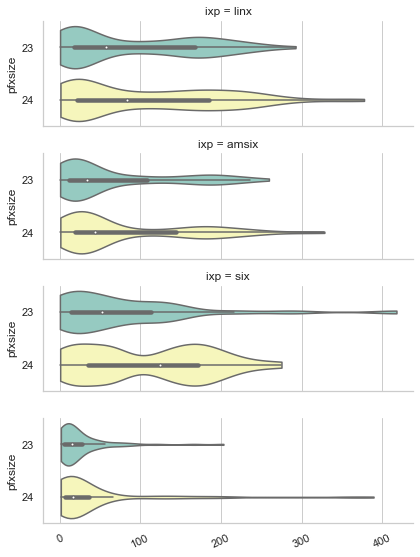

In [13]:
sns.set(rc = {'figure.figsize':(12,4)})


# Plot prepended vs not prepended path on ixp
fig=plt.figure(figsize=(12,4))
sns.set(font_scale = 1)
sns.set_style("whitegrid")    

g = sns.catplot(x="ms", y="pfxsize",
                hue="pfxsize", row="ixp",
                data=df[ (df['ixp']!='poaixbr') & (df['ms']<501) ],
                orient="h", height=2, aspect=3, palette="Set3",
                kind="violin", dodge=False, cut=0, bw=.3,
                legend = False)
g.set(xlabel=None)  # remove the axis label

plt.title('Evaluating prepended announcements on '+ixp.upper())
#ax.set_ylabel('Prefixes')
plt.xlabel('')
plt.title('')
#plt.ylabel('Prefixes')
plt.xticks(rotation = 25)
#ax.set(ylabel='', xlabel='mean RTT (ms)')


outfig=IMG+'rtt_diff.pdf'
print(f'Figure saved at {outfig}')
if (is_jupyter_notebook()):
    plt.savefig(outfig)
    plt.show()
else:
    plt.savefig(outfig)
    plt.close()


In [14]:
df=asrtt.set_index(['ixp','source_address_asn']).stack().rename('ms').reset_index()
df=df.rename(columns={'level_2':'pfxsize'})
df=df[df['ms']<501]
df.head(2)

,ixp,source_address_asn,pfxsize,ms
0,linx,1248,23,32.532240
1,linx,1248,24,266.776664


Figure saved at /Users/bertholdo/PAPERS/asym/leandro/rtt_violin.pdf


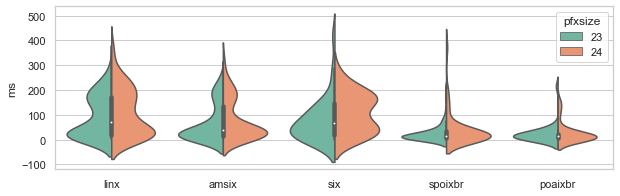

In [22]:
fig=plt.figure(figsize=(10,3))
ax = sns.violinplot(x="ixp", y="ms", hue="pfxsize",
                    data=df, palette="Set2", split=True,
                    scale="count")
plt.xlabel('')

outfig=IMG+'rtt_violin.pdf'
print(f'Figure saved at {outfig}')
if (is_jupyter_notebook()):
    plt.savefig(outfig, bbox_inches='tight')
    plt.show()
else:
    plt.savefig(outfig, bbox_inches='tight')
    plt.close()

In [ ]:
# Ases que nao tem as duas medidas de RTT = 75% (nao t
# m=sum([True for idx,row in df.iterrows() if any(row.isnull())])
# t=len(df)
# print(f' missing rows / total =', m/t)

In [ ]:
df.columns

In [ ]:
df.describe()

In [ ]:
rtt=df.groupby('source_address_asn', as_index=False)['send_receive_time_diff'].mean()

In [ ]:
rtt.sort_values('send_receive_time_diff', ascending=False)

In [ ]:
rtt['send_receive_time_diff'].describe()

In [ ]:
df[df['source_address_asn']==42].describe()

In [ ]:
df=pd.read_csv('rtt/nl_ams24_2022-04-19.csv',sep=';' , dtype=str)
df[df['source_address_asn']=='42']

In [ ]:
df.groupby(['source_address_asn', 'send_receive_time_diff']).mean()

In [ ]:
df